In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from itertools import product
from math import ceil
from utils import *

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
class MNISTEncoder(object):
    def __init__(self, emb_dim, sess):
        self.emb_dim = emb_dim
        self.sess = sess
        
        self.inputs = tf.placeholder("float32", [None, 28*28])
        self.labels = tf.placeholder("bool", [None])
        
        self._build_model()

    def _build_model(self):
        # Convolutional encoder
        x_image = tf.reshape(self.inputs, [-1,28,28,1])

        self.W_conv1 = weight_variable([5, 5, 1, 32])
        self.b_conv1 = bias_variable([32])
        self.h_conv1 = tf.nn.relu(conv2d(x_image, self.W_conv1) + self.b_conv1)
        self.h_pool1 = max_pool_2x2(self.h_conv1)

        self.W_conv2 = weight_variable([5, 5, 32, 64])
        self.b_conv2 = bias_variable([64])

        self.h_conv2 = tf.nn.relu(conv2d(self.h_pool1, self.W_conv2) + self.b_conv2)
        self.h_pool2 = max_pool_2x2(self.h_conv2)

        self.W_fc1 = weight_variable([7 * 7 * 64, self.emb_dim])
        self.b_fc1 = bias_variable([self.emb_dim])

        h_pool2_flat = tf.reshape(self.h_pool2, [-1, 7*7*64])
        self.emb = tf.matmul(h_pool2_flat, self.W_fc1) + self.b_fc1

        # L2 normalize
        self.norm_emb = tf.nn.l2_normalize(self.emb, 1)

    def get_norm_embedding(self, batch):
        return self.sess.run(self.norm_emb, feed_dict={self.inputs: batch})        
        
    def get_embedding(self, batch):
        return self.sess.run(self.emb, feed_dict={self.inputs: batch})

In [4]:

def magnet_loss(r, c, m, d, alpha=1.0):
    """Compute magnet loss for batch.
    
    Given a batch of features r consisting of m batches
    each with d assigned examples and a cluster separation
    gap of alpha, compute the total magnet loss and the per
    example losses.
    
    Args:
        r: A batch of features.
        c: Class labels for each example.
        m: The number of clusters in the batch.
        d: The number of examples in each cluster.
        alpha: The cluster separation gap hyperparameter.
        
    Returns:
        total_loss: The total magnet loss for the batch.
        losses: The loss for each example in the batch.
    
    """
    r = tf.verify_tensor_all_finite(r, 'reps bad')
    # Helper to compute indexes to select intra- and inter-cluster
    # distances
    def compute_comparison_inds():
        same_cluster_inds = []
        for i in range(m*d):
            c = i / d
            same_cluster_inds.append(c*d*m + c*d + (i % d))
        diff_cluster_inds = sorted(set(range(m*m*d)) - set(same_cluster_inds))
        
        return same_cluster_inds, diff_cluster_inds

        
    # Take cluster means within the batch
    cluster_means = tf.reduce_mean(tf.reshape(r, [m, d, -1]), 1)

    # Compute squared distance of each example to each cluster centroid
    sample_cluster_pair_inds = np.array(list(product(range(m), range(m*d))))
    sample_costs = tf.squared_difference(
        tf.gather(cluster_means, sample_cluster_pair_inds[:,0]),
        tf.gather(r, sample_cluster_pair_inds[:,1]))
    sample_costs = tf.reduce_sum(sample_costs, 1)
    
    # Compute intra- and inter-cluster comparison indexes
    same_cluster_inds, diff_cluster_inds = compute_comparison_inds()
    
    # Select distances of examples to their own centroid
    intra_cluster_costs = tf.gather(sample_costs, same_cluster_inds)
    intra_cluster_costs = tf.reshape(intra_cluster_costs, [m, d])
    
    # Compute variance of intra-cluster squared distances
    variance = tf.reduce_sum(intra_cluster_costs) / (m * d - 1)
    var_normalizer = -1 / 2*variance**2

    # Compute numerator of inner term
    numerator = tf.reshape(tf.transpose(tf.exp(var_normalizer * intra_cluster_costs - alpha)), [m*d])

    # To compute denominator, select distances of examples to other class centroids
    cluster_classes = tf.strided_slice(c, [0], [m*d], [d])
    diff_class_mask = tf.logical_not(tf.equal(tf.expand_dims(c, 1), tf.expand_dims(cluster_classes, 0)))
    denom_sample_costs = tf.exp(var_normalizer * tf.transpose(tf.reshape(sample_costs, [m, -1])))
    diff_class_sample_costs = tf.select(diff_class_mask, denom_sample_costs, tf.zeros([m*d, m]))
    denominator = tf.reduce_sum(diff_class_sample_costs, 1)
    
    denominator = tf.verify_tensor_all_finite(denominator, 'denom bad')
    numerator = tf.verify_tensor_all_finite(numerator, 'numer bad')

    # Compute example losses and total loss
    losses = tf.nn.relu(-tf.log(numerator / (denominator + 1e-8) + 1e-8))
    losses = tf.verify_tensor_all_finite(losses, 'losses bad')
    total_loss = tf.reduce_mean(losses)
    
    return total_loss, losses





# sess = tf.InteractiveSession()

# m = 6
# d = 4

# K = 5
# alpha = 15.0

# r = tf.placeholder(tf.float32, [m*d, 8])
# c = tf.placeholder(tf.int32, [m*d])
# # magnet_loss2, losses2, cc = magnet_loss(r, c, m, d, alpha)
# alpha_placeholder = tf.placeholder(tf.float32)
# total_loss, example_losses = magnet_loss(r, c, m, d, alpha_placeholder)


# # Helper to generate debug data
# def gen_data(m, d):
#     data = []
#     for c in range(m):
#         a = (c + 1) * 3
#         centroid = np.random.random([1, 8]) * a
#         data.append(centroid + np.random.random([d, 8]))
#     return np.vstack(data)


# # feed_dict = {r: np.random.random([m*d, 8])}
# rdata = gen_data(m, d)
# classes = np.repeat([0, 1, 1, 3, 4, 5], d)
# feed_dict = {r: rdata, c: classes, alpha_placeholder: alpha}

# print sess.run([total_loss], feed_dict=feed_dict)


# sess.close()
# tf.reset_default_graph()

In [ ]:
feed_dict = {r: rdata, c: classes, alpha_placeholder: 17.}
print sess.run([total_loss], feed_dict=feed_dict)

In [ ]:
sess.close()
tf.reset_default_graph()

In [5]:
from sklearn.cluster import KMeans

class ClusterBatchBuilder(object):
    def __init__(self, labels, k, m, d):
        
        self.num_classes = np.unique(labels).shape[0]
        self.labels = labels

        self.k = k
        self.m = m
        self.d = d

        self.centroids = None
        self.assignments = np.zeros_like(labels, int)
        self.cluster_assignments = {}
        self.cluster_classes = np.repeat(range(self.num_classes), k)
        self.example_losses = None
        self.cluster_losses = None

    
    def update_clusters(self, rep_data, max_iter=20):
        """
        Given an array of representations for the entire training set,
        recompute clusters and store example cluster assignments in a
        quickly sampleable form.
        """
        # Lazily allocate array for centroids
        if self.centroids is None:
            self.centroids = np.zeros([self.num_classes * self.k, rep_data.shape[1]])
        
        for c in range(self.num_classes):

            class_mask = self.labels == c
            class_examples = rep_data[class_mask]
            kmeans = KMeans(n_clusters=self.k, init='k-means++', n_init=1, max_iter=max_iter)
            kmeans.fit(class_examples)

            # Save cluster centroids for finding impostor clusters
            start = self.get_cluster_ind(c, 0)
            stop = self.get_cluster_ind(c, self.k)
            self.centroids[start:stop] = kmeans.cluster_centers_

            # Update assignments with new global cluster indexes
            self.assignments[class_mask] = self.get_cluster_ind(c, kmeans.predict(class_examples))
            
        # Construct a map from cluster to example indexes for fast batch creation
        for cluster in range(self.k * self.num_classes):
            cluster_mask = self.assignments == cluster
            self.cluster_assignments[cluster] = np.flatnonzero(cluster_mask)

        
    def update_losses(self, indexes, losses):
        """
        Given a list of examples indexes and corresponding losses
        store the new losses and update corresponding cluster losses.
        """
        # Lazily allocate structures for losses
        if self.example_losses is None:
            self.example_losses = np.zeros_like(self.labels, float)
            self.cluster_losses = np.zeros([self.k * self.num_classes], float)

        # Update example losses
        self.example_losses[np.array(indexes)] = losses
        
        # Find affected clusters and update the corresponding cluster losses
        clusters = np.unique(self.assignments[indexes])
        for cluster in clusters:
            cluster_example_losses = self.example_losses[self.assignments == cluster]
            self.cluster_losses[cluster] = np.mean(cluster_example_losses)

        
    def gen_batch(self):
        """
        Sample a batch by first sampling a seed cluster proportionally to
        the mean loss of the clusters, then finding nearest neighbor
        "impostor" clusters, then sampling d examples uniformly from each cluster.
        
        The generated batch will consist of m clusters each with d consecutive
        examples.
        """
        
        # Sample seed cluster proportionally to cluster losses if available
        if self.cluster_losses is not None:
            p = self.cluster_losses / np.sum(self.cluster_losses)
            seed_cluster = np.random.choice(self.num_classes * self.k, p=p)
            print p
        else:
            seed_cluster = np.random.choice(self.num_classes * self.k)

        # Get imposter clusters by ranking centroids by distance
        sq_dists = ((self.centroids[seed_cluster] - self.centroids) ** 2).sum(axis=1)
        
        # Assure only clusters of different class from seed are chosen
        sq_dists[self.get_class_ind(seed_cluster) == self.cluster_classes] = np.inf
        
        # Get top impostor clusters and add seed
        clusters = np.argpartition(sq_dists, self.m-1)[:self.m-1]
        clusters = np.concatenate([[seed_cluster], clusters])
        
        # Sample examples uniformly from cluster
        batch_indexes = np.empty([self.m * self.d], int)
        for i, c in enumerate(clusters):
            x = np.random.choice(self.cluster_assignments[c], self.d, replace=False)
            start = i * self.d
            stop = start + self.d
            batch_indexes[start:stop] = x

        # Translate class indexes to index for classes within the batch
        class_inds = self.get_class_ind(clusters)
        batch_class_inds = []
        inds_map = {}
        class_count = 0
        for c in class_inds:
            if c not in inds_map:
                inds_map[c] = class_count
                class_count += 1
            batch_class_inds.append(inds_map[c])

        return batch_indexes, np.repeat(batch_class_inds, self.d)

    
    def get_cluster_ind(self, c, i):
        """
        Given a class index and a cluster index within the class
        return the global cluster index
        """
        return c * self.k + i
    
    def get_class_ind(self, c):
        """
        Given a cluster index return the class index.
        """
        return c / self.k
    

# rep = np.random.random([mnist.train.images.shape[0], 8])
# batch_builder = ClusterBatchBuilder(mnist.train.labels, 5, 12, 4)
# batch_builder.update_clusters(rep)
# batch_builder.update_losses(range(mnist.train.labels.shape[0]), np.random.random([mnist.train.labels.shape[0]]))
# example_inds, class_inds = batch_builder.gen_batch()
# print example_inds, class_inds


In [10]:
# Define magnet loss parameters
m = 8
d = 8
k = 3
alpha = 1.0
batch_size = m * d

# Define training data
X = mnist.train.images
y = mnist.train.labels

# Define model and training parameters
epoch_steps = int(ceil(float(X.shape[0]) / batch_size)) 
emb_dim = 2
num_steps = epoch_steps * 10
cluster_refresh_interval = epoch_steps



sess = tf.InteractiveSession()

# Model
with tf.variable_scope('model'):
    model = MNISTEncoder(emb_dim, sess)

# Loss
with tf.variable_scope('magnet_loss'):
    class_inds = tf.placeholder(tf.int32, [m*d])
    train_loss, losses = magnet_loss(model.emb, class_inds, m, d, alpha)

train_op = tf.train.AdamOptimizer(1e-4).minimize(train_loss)

sess.run(tf.initialize_all_variables())



def compute_reps(extract_fn, X, chunk_size):
    chunks = int(ceil(float(X.shape[0]) / chunk_size))
    reps = []
    for i in range(chunks):
        start = i * chunk_size
        stop = start + chunk_size
        chunk_reps = extract_fn(X[start:stop])
        reps.append(chunk_reps)
    return np.vstack(reps)

# Get initial embedding
extract = lambda x: sess.run(model.emb, feed_dict={model.inputs: x})
initial_reps = compute_reps(extract, X, 400)


# Create batcher
batch_builder = ClusterBatchBuilder(mnist.train.labels, k, m, d)
batch_builder.update_clusters(initial_reps)

for i in range(num_steps):
    
    batch_example_inds, batch_class_inds = batch_builder.gen_batch()
    feed_dict = {model.inputs: X[batch_example_inds], class_inds: batch_class_inds}
    _, batch_loss = sess.run([train_op, train_loss], feed_dict=feed_dict)
    
    if not i % 100:
        print i, batch_loss
    
    if not i % cluster_refresh_interval:
        print 'Refreshing clusters'
        reps = compute_reps(extract, X, 400)
        batch_builder.update_clusters(reps)
        
final_reps = compute_reps(extract, X, 400)
    
sess.close()
tf.reset_default_graph()

(55000, 2)
0 2.83612
Refreshing clusters
100 1.56442
200 0.981482
300 1.00971
400 1.26876
500 0.471099
600 0.635387
700 0.324143
800 0.651589
Refreshing clusters
900 0.503299
1000 0.939433
1100 1.9305
1200 0.827377
1300 0.888049
1400 0.947839
1500 1.19578
1600 0.365063
1700 0.595111
Refreshing clusters
1800 0.431402
1900 0.816492
2000 0.534033
2100 0.683767
2200 0.932488
2300 0.592166
2400 1.19646
2500 0.571042
Refreshing clusters
2600 1.13925
2700 0.986526
2800 1.2647
2900 0.412612
3000 0.163003
3100 0.164438
3200 0.628266
3300 0.560593
3400 0.280469
Refreshing clusters
3500 0.629221
3600 0.319491
3700 0.410364
3800 0.184186
3900 0.320354
4000 0.411475
4100 1.06164
4200 0.0341445
4300 0.0453952
Refreshing clusters
4400 0.547032
4500 0.518291
4600 0.300733
4700 0.836603
4800 0.222402
4900 0.379678
5000 0.576968
5100 0.305746
Refreshing clusters
5200 0.461265
5300 0.0384804
5400 1.23391
5500 0.201667
5600 0.45467
5700 0.659878
5800 0.64569
5900 0.238472
6000 0.446666
Refreshing clusters

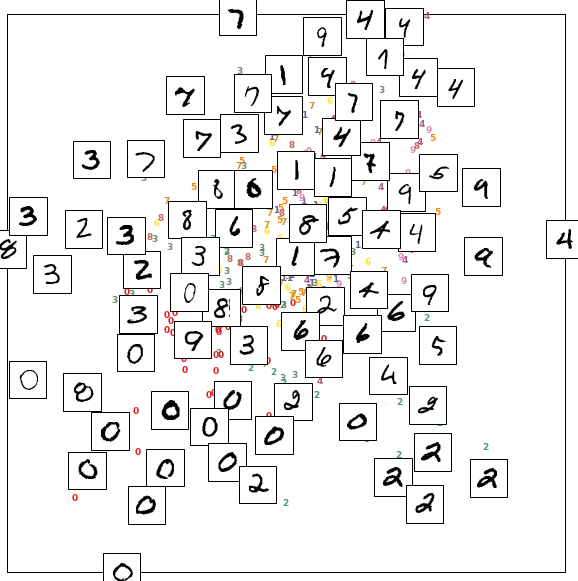

In [11]:
num_plot = 500
imgs = mnist.train.images[:num_plot]
imgs = np.reshape(imgs, [num_plot, 28, 28])
plot_embedding(initial_reps[:num_plot], mnist.train.labels[:num_plot], imgs)

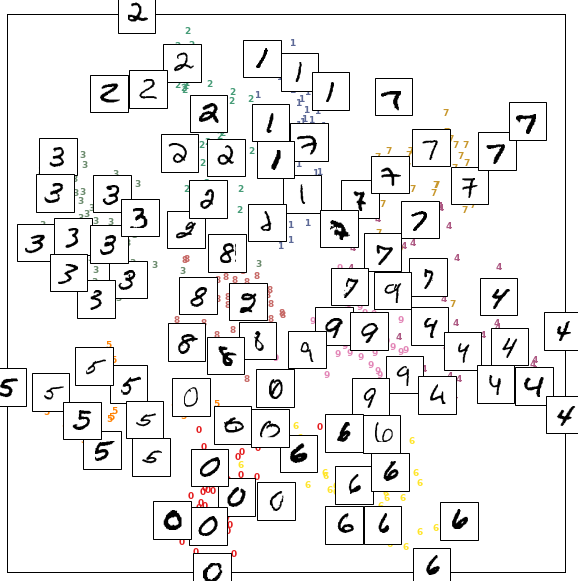

In [12]:
num_plot = 500
imgs = mnist.train.images[:num_plot]
imgs = np.reshape(imgs, [num_plot, 28, 28])
plot_embedding(final_reps[:num_plot], mnist.train.labels[:num_plot], imgs)